In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
train_dir = '/content/drive/MyDrive/dataset/train'
test_dir = '/content/drive/MyDrive/dataset/test'

In [ ]:
def get_image(path):
    img = cv2.imread(path)
    print(img.shape)
    plt.imshow(img)

In [ ]:
def datapreprocessing(main_dir,bsize):
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    train_gen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=0.2,
                                   shear_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   #validation_split=0.3,
                                   fill_mode='nearest',
                                  )

    train_generator = train_gen.flow_from_directory(
        directory=main_dir,
        target_size=(48,48),
        batch_size=bsize,
        color_mode="rgb",
        shuffle=True,
        subset="training",
        class_mode='categorical')

    return train_generator

In [ ]:
traingen = datapreprocessing(train_dir,20)
validgen = datapreprocessing(test_dir,20)

Found 2249 images belonging to 4 classes.
Found 698 images belonging to 4 classes.


In [ ]:
labelnames = traingen.class_indices
labelnames

{'crack': 0, 'dot': 1, 'good': 2, 'joint': 3}

In [ ]:
#Function that can build a dataframe on passing folderpath.
def getdata(folder_path):
    sig = pd.DataFrame(columns=['image_abs_path','image_labels'])
    for key,value in labelnames.items():
        #print("processing for label: {}".format(label))
        label_i = folder_path+"/"+str(key)
        #read directory
        dirs_label_i =  os.listdir(label_i)
        idx = 0
        for image in dirs_label_i:
            #create a absolute image path
            sig_i = os.path.join(label_i,image)
            #print('Absolute path for image no. {} and label {}: {}'\
                  #.format(idx,label,flower_i))

            #fill the dataframe with path and label
            sig = sig.append({'image_abs_path':sig_i,
                            'image_labels':key},
                           ignore_index=True)
            idx += 1
    return sig

In [ ]:
#Create Train Dataframe as repository of paths and labels.
valid = getdata(test_dir)

<ipython-input-8-acc0039d2d8c>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sig = sig.append({'image_abs_path':sig_i,
<ipython-input-8-acc0039d2d8c>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sig = sig.append({'image_abs_path':sig_i,
<ipython-input-8-acc0039d2d8c>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sig = sig.append({'image_abs_path':sig_i,
<ipython-input-8-acc0039d2d8c>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sig = sig.append({'image_abs_path':sig_i,
<ipython-input-8-acc0039d2d8c>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.

In [ ]:

def get_n_images(n,df,label):
    import warnings
    warnings.filterwarnings('ignore')
    train = df[df["image_labels"]==label]
    print(len(train))
    i = 0
    m = int(n/2)
    plt.figure(figsize=(12, 6))
    for path in train['image_abs_path'][0:n]:
        plt.subplot(2,m,i+1)
        get_image(path)
        i += 1
    plt.tight_layout()
    plt.show()

In [ ]:
def visualize_gen(train_generator):
    #Visualising Images Processed
    plt.figure(figsize=(12, 6))
    for i in range(0, 10):
        plt.subplot(2, 5, i+1)
        for X_batch, Y_batch in train_generator:
            image = X_batch[0]
            plt.axis("off")
            plt.imshow((image*255).astype(np.uint8))
            break
    plt.tight_layout()
    plt.show()

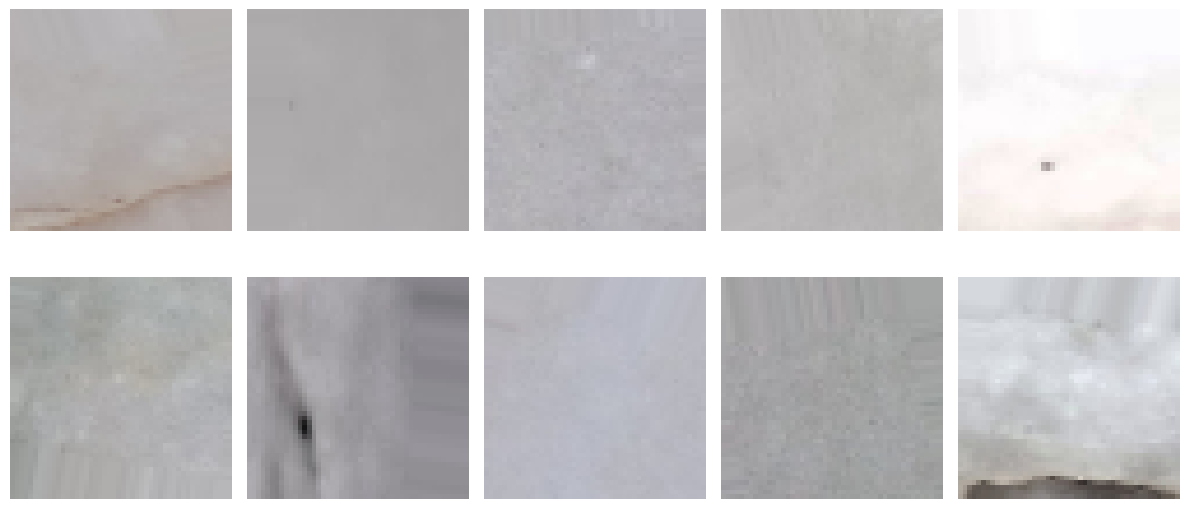

In [ ]:
visualize_gen(traingen)

In [ ]:
#Get the shape of images
input_shape = traingen.image_shape
input_shape

(48, 48, 3)

In [ ]:
def imageclf2(input_shape):
    from tensorflow import keras as ks
    #from tensorflow.keras import regularizers
    model = ks.models.Sequential()
    #building architecture
    #Adding layers
    model.add(ks.layers.Conv2D(8,(3,3),
                               strides=1,
                               activation="relu",
                               padding='same',
                               name="layer1",
                               input_shape=input_shape))
    model.add(ks.layers.MaxPooling2D(pool_size=2,strides=2))
    model.add(ks.layers.Dropout(0.2))
    model.add(ks.layers.Conv2D(8,(3,3),strides=1,padding="same",activation="relu",name="layer2"))
    model.add(ks.layers.MaxPooling2D(pool_size=2,strides=2))


    model.add(ks.layers.Flatten())
    model.add(ks.layers.Dense(128,activation="relu",
                              name="layer5"))
    model.add(ks.layers.Dropout(0.2))

    model.add(ks.layers.Dense(4,activation="softmax",name="output"))
    model.summary()

    return model

In [ ]:
model01 = imageclf2(input_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Conv2D)             (None, 48, 48, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 8)         0         
                                                                 
 layer2 (Conv2D)             (None, 24, 24, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1152)              0

In [ ]:
def compiler2(model,train_generator,valid_generator,epchs,bsize=32,lr=0.0001):

    from tensorflow import keras as ks
    callbck = ks.callbacks.EarlyStopping(monitor='val_loss',patience=10,
                                         verbose=2,
                                         restore_best_weights=True,)

    opt = ks.optimizers.Adam(learning_rate=lr)

    model.compile(loss="categorical_crossentropy",
                      optimizer=opt,
                      metrics=["accuracy"])
    history = model.fit(train_generator,
                        epochs=epchs,
                        callbacks=[callbck],
                        validation_data=valid_generator,
                        verbose = 1,
                        #steps_per_epoch = train_generator.n // bsize
                       )
    #Visualise curves
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='valid_acc')

    plt.title('lrate='+str(lr), pad=-50)
    plt.legend()
    plt.grid(True)
    return model,history

Epoch 1/100
113/113 [==============================] - 983s 9s/step - loss: 1.1875 - accuracy: 0.4317 - val_loss: 1.1639 - val_accuracy: 0.5573
Epoch 2/100
113/113 [==============================] - 18s 156ms/step - loss: 1.1652 - accuracy: 0.4446 - val_loss: 1.1518 - val_accuracy: 0.4943
Epoch 3/100
113/113 [==============================] - 19s 172ms/step - loss: 1.1542 - accuracy: 0.4571 - val_loss: 1.1475 - val_accuracy: 0.4957
Epoch 4/100
113/113 [==============================] - 19s 170ms/step - loss: 1.1441 - accuracy: 0.4744 - val_loss: 1.1365 - val_accuracy: 0.5415
Epoch 5/100
113/113 [==============================] - 19s 170ms/step - loss: 1.1233 - accuracy: 0.5104 - val_loss: 1.1414 - val_accuracy: 0.5272
Epoch 6/100
113/113 [==============================] - 19s 168ms/step - loss: 1.0858 - accuracy: 0.5518 - val_loss: 1.0919 - val_accuracy: 0.5788
Epoch 7/100
113/113 [==============================] - 19s 170ms/step - loss: 1.0519 - accuracy: 0.5914 - val_loss: 1.0532 - v

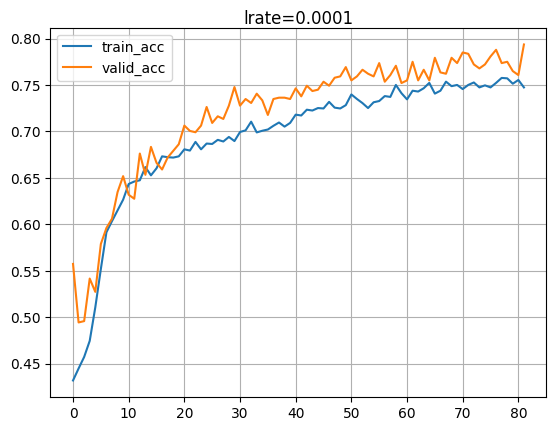

In [ ]:
model_com01 = compiler2(model01,traingen,validgen,100)

In [ ]:
def get_predictions(n):
    from tensorflow import keras as ks
    image1= validgen[0][0][n]

    plt.imshow(image1)
    input_arr = ks.preprocessing.image.img_to_array(validgen[0][0][n])
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    predictions = np.argmax(model_com01[0].predict(input_arr),axis=1)

    return predictions

1/1 [==============================] - 0s 122ms/step


array([2])

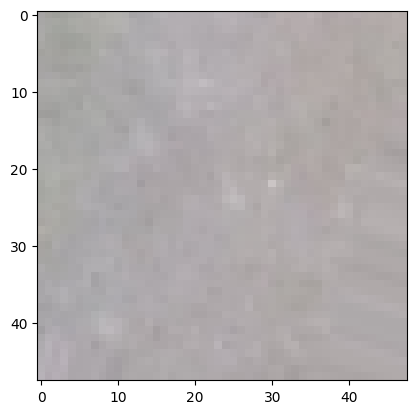

In [ ]:
get_predictions(11)

256
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


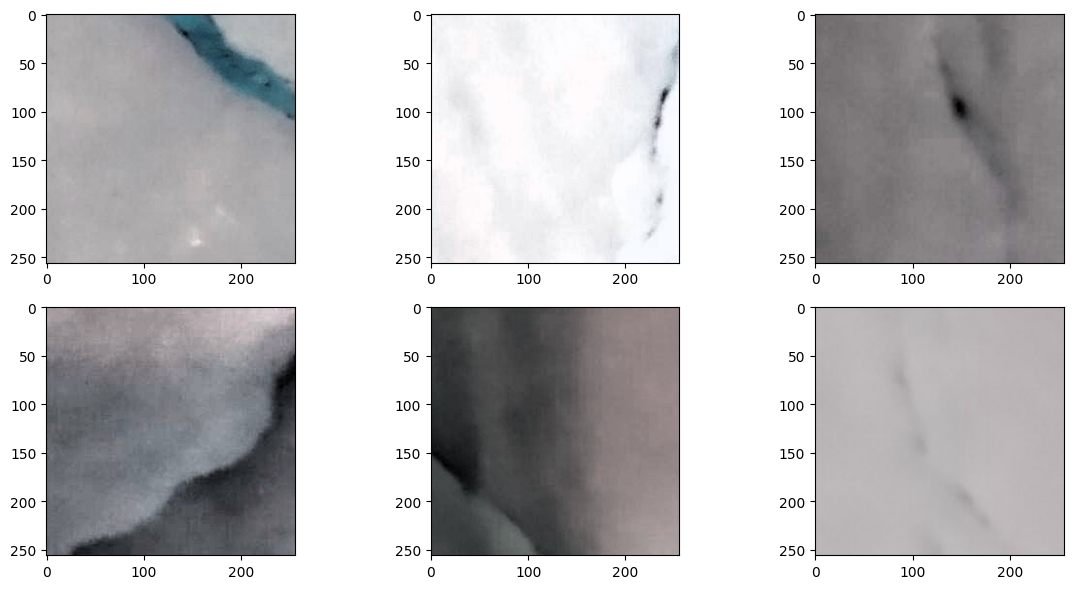

In [ ]:
get_n_images(6,valid,'crack')

In [ ]:
# save the model to disk
model = model_com01[0]
model.save('/content/drive/MyDrive/saved_models/MarbleModel.tf')

In [ ]:
from keras.models import load_model


In [ ]:
# Load the saved model
loaded_model = load_model('/content/drive/MyDrive/saved_models/MarbleModel.tf')


In [ ]:
true_classes = traingen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds_ft = loaded_model.predict(traingen)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)


113/113 [==============================] - 732s 7s/step


In [1]:
!pip freeze

absl-py==1.4.0
altair==5.0.1
anyio==4.0.0
appnope==0.1.3
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.0
astunparse==1.6.3
async-lru==2.0.4
attrs==23.1.0
Babel==2.13.0
backcall==0.2.0
beautifulsoup4==4.12.2
bleach==6.1.0
blinker==1.6.2
boltons @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_f63n9uulmp/croot/boltons_1677628710094/work
brotlipy==0.7.0
cachetools==5.3.1
certifi @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_5d968ni_yn/croot/certifi_1671487774636/work/certifi
cffi @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_ab19r4bji3/croot/cffi_1670423206034/work
charset-normalizer @ file:///tmp/build/80754af9/charset-normalizer_1630003229654/work
click==8.1.6
comm==0.1.4
conda==23.3.1
conda-content-trust @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_11146a2b-93c2-444c-a378-ad4fac363e991s0r1hnp/croots/recipe/conda-content-trust_1658126383571/work
conda-package-hand

In [2]:
!pip freeze > requirements.txt